In [98]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import math

# DATASET ANALYSIS

### DATA LOADING

In [99]:
def read_csv(file_path):
    """Reads a CSV file and returns its content as a list of dictionaries."""
    with open(file_path, mode='r', newline='', encoding='utf-8') as csvfile:
        reader = csv.DictReader(csvfile)
        return [row for row in reader]


In [100]:
dataset_path= './dataset/diabetes_prediction_dataset.csv'
data = read_csv(dataset_path)
df= pd.DataFrame(data)
df

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...,...
99995,Female,80.0,0,0,No Info,27.32,6.2,90,0
99996,Female,2.0,0,0,No Info,17.37,6.5,100,0
99997,Male,66.0,0,0,former,27.83,5.7,155,0
99998,Female,24.0,0,0,never,35.42,4.0,100,0


### DATA PREPARATION

In [101]:
# count the duplicates
df.duplicated().sum()

3854

In [102]:
df.drop_duplicates(inplace=True)

In [141]:
df.duplicated().sum()

0

In [103]:
df['gender'].value_counts()

gender
Female    56161
Male      39967
Other        18
Name: count, dtype: int64

In [104]:
df['diabetes'].value_counts()

diabetes
0    87664
1     8482
Name: count, dtype: int64

--> Unbalanced dataset

In [105]:
df['smoking_history'].unique()

array(['never', 'No Info', 'current', 'former', 'ever', 'not current'],
      dtype=object)

In [106]:
# how many genres are there?
df['gender'].unique()

array(['Female', 'Male', 'Other'], dtype=object)

In [107]:
# encode the categorical columns
df['gender_encoded'] = LabelEncoder().fit_transform(df['gender'])
df['smoking_encoded'] = LabelEncoder().fit_transform(df['smoking_history'])
df = df.drop(columns=['gender','smoking_history'])

In [108]:
#make sure every column is numeric
for col in df.columns:
    if not pd.api.types.is_numeric_dtype(df[col]):
        df[col] = pd.to_numeric(df[col], errors='coerce')

In [109]:
df.head()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,gender_encoded,smoking_encoded
0,80.0,0,1,25.19,6.6,140,0,0,4
1,54.0,0,0,27.32,6.6,80,0,0,0
2,28.0,0,0,27.32,5.7,158,0,1,4
3,36.0,0,0,23.45,5.0,155,0,0,1
4,76.0,1,1,20.14,4.8,155,0,1,1


### Correlation matrix

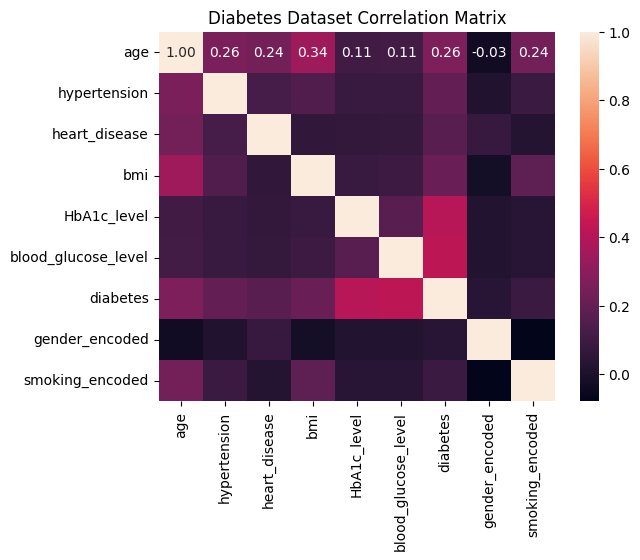

In [110]:
# correlation matrix
sns.heatmap(df.corr(), annot=True, fmt='.2f')
plt.title('Diabetes Dataset Correlation Matrix')
plt.show()

Conclusion : highly correlated parameters are diabetes and blood_glucode_level and HbA1c_level  
bmi and age are also slightly correlated

### Outliers

In [123]:
def plot_all_boxplots(df_input, cols_per_row=3, figsize=(12, 8)):
    """
    Plot boxplots for all numeric columns in the DataFrame.
    Args:
        df_input (pd.DataFrame): DataFrame to plot.
        cols_per_row (int): Number of plots per row.
        figsize (tuple): Figure size.
    """
    plt.close('all')  # Reset/clear all previous figures

    numeric_cols = df_input.select_dtypes(include='number').columns
    nrows = math.ceil(len(numeric_cols) / cols_per_row)
    fig, axes = plt.subplots(nrows=nrows, ncols=cols_per_row, figsize=figsize, sharex=True)
    axes = axes.flatten()
    for i, ax in enumerate(axes):
        if i < len(numeric_cols):
            ax.boxplot(df_input[numeric_cols[i]].dropna(),
                       flierprops=dict(markeredgecolor='red'),
                       showmeans=True)
            ax.set_title(numeric_cols[i])
        else:
            ax.axis('off')
    plt.tight_layout()
    plt.show()

#

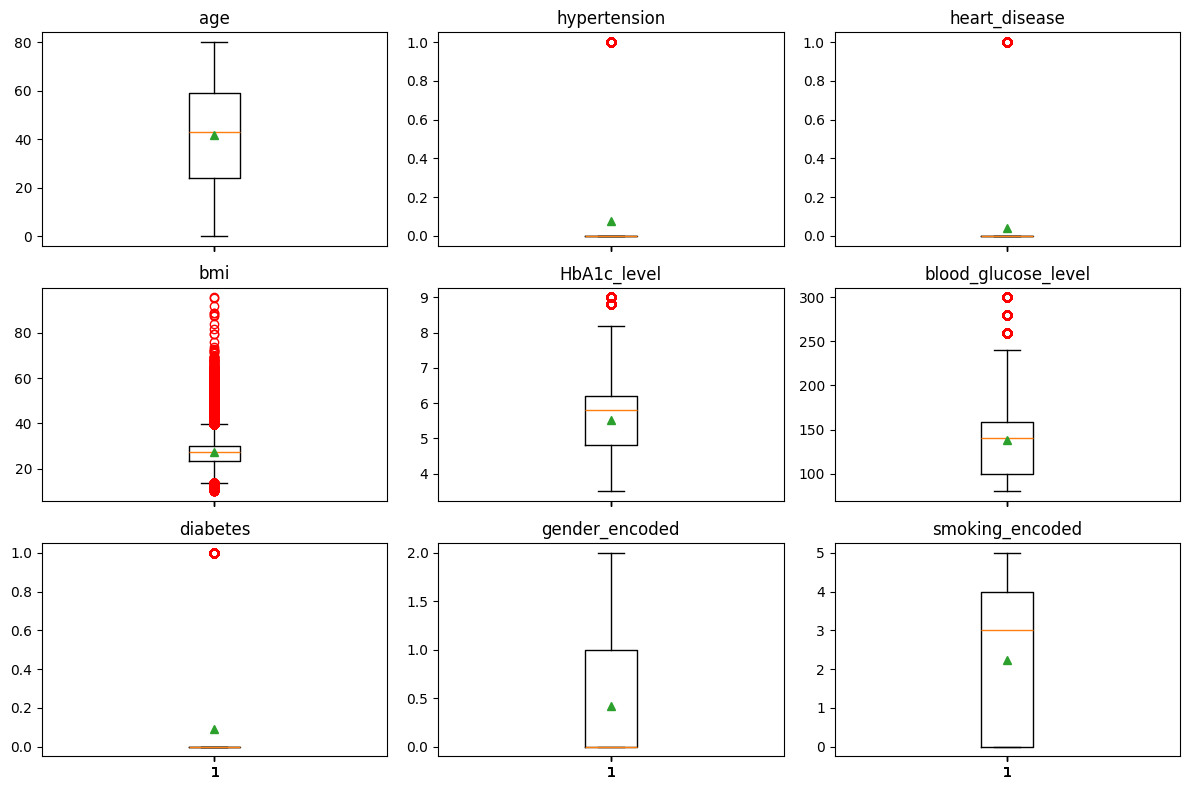

In [124]:
plot_all_boxplots(df)

We don't want to remove the outliers because if we do one class disapear.  


### balance dataset

In [167]:

# Separate majority and minority classes
majority = df[df['diabetes'] == 0]
minority = df[df['diabetes'] == 1]

majority_count = len(majority)
minority_count = len(minority)
print(f"Majority class count: {majority_count}, Minority class count: {minority_count}")

# Downsample majority class
majority_downsampled = majority.sample(n=minority_count, random_state=42)

# Combine minority class with downsampled majority class
df_balanced = pd.concat([majority_downsampled, minority])

# Shuffle the dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Vérifie la nouvelle répartition
print(df_balanced['diabetes'].value_counts())


Majority class count: 87664, Minority class count: 8482
diabetes
1    8482
0    8482
Name: count, dtype: int64


### Save preprocessed dataset

In [168]:
df_balanced.to_csv('./dataset/diabetes_prediction_dataset_preprocessed.csv', index=False)

### Split dataset

In [169]:
from sklearn.model_selection import train_test_split
X = df_balanced.drop(columns=['diabetes'])
y = df_balanced['diabetes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)
print(f"Training set size: {len(X_train)}, Test set size: {len(X_test)}")
#save the split datasets
X_train.to_csv('./dataset/splits/X_train.csv', index=False)
X_test.to_csv('./dataset/splits/X_test.csv', index=False)
y_train.to_csv('./dataset/splits/y_train.csv', index=False)    
y_test.to_csv('./dataset/splits/y_test.csv', index=False)

Training set size: 13571, Test set size: 3393
